# Experiment Design

### Objective
Evaluate, via A/B testing, whether free shipping on orders ≥ 100 BRL increases total revenue.

### Question to address
Should free shipping for orders above 100 BRL be implemented?

### Approach
1. Define hypotheses (null vs. increase in revenue).
2. Select primary/secondary metrics.
3. Compute required sample size (power, alpha, MDE).
4. Plan randomization and assignment.


In [1]:
%matplotlib widget

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

from matplotlib import rcParams
import shutil

# Enable LaTeX fonts only if TeX is available
if shutil.which("latex"):
    rcParams['text.usetex'] = True
    rcParams['font.family'] = 'serif'
else:
    print("LaTeX not found — using default matplotlib fonts.")

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
# Load the order-level data we prepared in Notebook 01
order_totals = pd.read_csv('../data/processed/order_totals.csv')

print("Data loaded successfully!")
print("Number of orders:", len(order_totals))
print("\nFirst 5 rows:")
print(order_totals.head())

Data loaded successfully!
Number of orders: 98666

First 5 rows:
                           order_id  total_price  total_shipping  num_items  \
0  00010242fe8c5a6d1ba2dd792cb16214        58.90           13.29          1   
1  00018f77f2f0320c557190d7a144bdd3       239.90           19.93          1   
2  000229ec398224ef6ca0657da4fc703e       199.00           17.87          1   
3  00024acbcdf0a6daa1e931b038114c75        12.99           12.79          1   
4  00042b26cf59d7ce69dfabb4e55b4fd9       199.90           18.14          1   

   order_total  
0        72.19  
1       259.83  
2       216.87  
3        25.78  
4       218.04  


## Hypothesis Definition

### Null hypothesis (H0)
Free shipping for orders ≥ 100 BRL has no effect on revenue per customer.  
$$\mu_{\text{treatment}} = \mu_{\text{control}}$$

### Alternative hypothesis (H1)
Free shipping for orders ≥ 100 BRL increases revenue per customer.  
$$\mu_{\text{treatment}} > \mu_{\text{control}}$$

### Explanation
- **$\mu_{\text{control}}$**: Average revenue per customer in the control group (no free shipping).  
- **$\mu_{\text{treatment}}$**: Average revenue per customer in the treatment group (offered free shipping).  

If both means are equal, the promotion has no effect.  
If the treatment mean is higher, free shipping increases customer spending.


In [4]:
# Calculate baseline metrics from historical data

# Primary metric: Revenue per order (what customer pays)
baseline_revenue = order_totals['order_total'].mean()

# Secondary metrics
baseline_price = order_totals['total_price'].mean()
baseline_shipping = order_totals['total_shipping'].mean()
baseline_items = order_totals['num_items'].mean()

print("BASELINE METRICS (Current State):")
print("="*50)
print(f"Mean revenue per order: {baseline_revenue:.2f} BRL")
print(f"Mean product price per order: {baseline_price:.2f} BRL")
print(f"Mean shipping per order: {baseline_shipping:.2f} BRL")
print(f"Mean items per order: {baseline_items:.2f} items")

print("\n")

# Calculate standard deviation (we'll need this for power analysis)
revenue_std = order_totals['order_total'].std()
print(f"Standard deviation of revenue: {revenue_std:.2f} BRL")

BASELINE METRICS (Current State):
Mean revenue per order: 160.58 BRL
Mean product price per order: 137.75 BRL
Mean shipping per order: 22.82 BRL
Mean items per order: 1.14 items


Standard deviation of revenue: 220.47 BRL


In [5]:
# Minimum Detectable Effect (MDE)
# This is the smallest change we care about detecting

# We want to detect at least a 5% increase in revenue
minimum_effect_percentage = 5.0

# Calculate what this means in absolute terms
minimum_effect_brl = baseline_revenue * (minimum_effect_percentage / 100)

print("MINIMUM DETECTABLE EFFECT:")
print("="*50)
print(f"We want to detect at least: {minimum_effect_percentage}% increase")
print(f"In absolute terms: {minimum_effect_brl:.2f} BRL per order")
print(f"\nCurrent mean revenue: {baseline_revenue:.2f} BRL")
print(f"Target mean revenue: {baseline_revenue + minimum_effect_brl:.2f} BRL")

print("\n")

# Business justification
print("BUSINESS JUSTIFICATION:")
print("="*50)
print(f"Average shipping cost absorbed: {baseline_shipping:.2f} BRL")
print(f"Required revenue increase to break even: {baseline_shipping:.2f} BRL")
print(f"Our target increase: {minimum_effect_brl:.2f} BRL")

if minimum_effect_brl > baseline_shipping:
    print("Target increase covers shipping costs!")
else:
    print("Target increase may not fully cover shipping costs")

MINIMUM DETECTABLE EFFECT:
We want to detect at least: 5.0% increase
In absolute terms: 8.03 BRL per order

Current mean revenue: 160.58 BRL
Target mean revenue: 168.61 BRL


BUSINESS JUSTIFICATION:
Average shipping cost absorbed: 22.82 BRL
Required revenue increase to break even: 22.82 BRL
Our target increase: 8.03 BRL
Target increase may not fully cover shipping costs


## Understanding

### Note on Shipping Costs
The assumed 5% revenue increase (about 8 BRL) is smaller than the average shipping cost (about 23 BRL). This is expected and realistic.

### Key Points

**1. Only some customers qualify**
- Free shipping applies only to orders with value $$\geq 100 \text{ BRL}$$  
- About 42% of orders are already above this level  
- We absorb shipping costs only for these customers

**2. Main impact is on smaller orders**
- Around 58% of orders fall below 100 BRL  
- Many of these customers are expected to add items to qualify  
- Their basket size can grow by 20–30 BRL or more

**3. Average effect across all treatment customers**
- The treatment group includes:
  - Customers already above 100 BRL (no behavior change, cost absorbed)
  - Customers below 100 BRL (increase spending to qualify)
- The 5% increase represents the blended average across both groups

### Example
- 100 customers in the treatment group  
- 42 already spend $$\geq 100 \text{ BRL}$$ — no change, company absorbs about 23 BRL each  
- 58 spend below 100 BRL — many add 20–30 BRL to reach the threshold  
- Overall, this results in an average revenue increase of about 5–8%.


In [6]:
# Power Analysis: How many customers do we need in each group?

# Statistical parameters
alpha = 0.05  # Significance level (5% chance of false positive)
beta = 0.20   # 20% chance of false negative
power = 1 - beta  # 80% power

# Effect size (standardized)
effect_size = minimum_effect_brl / revenue_std

print("POWER ANALYSIS PARAMETERS:")
print("="*50)
print(f"Significance level (alpha): {alpha}")
print(f"Power (1-beta): {power}")
print(f"Effect size: {effect_size:.4f}")
print(f"Standard deviation: {revenue_std:.2f} BRL")

print("\n")

# Calculate required sample size per group
# Formula: n = 2 * (Z_alpha + Z_beta)^2 * (std^2) / (effect^2)

z_alpha = stats.norm.ppf(1 - alpha/2)  # Two-tailed test
z_beta = stats.norm.ppf(power)

numerator = 2 * ((z_alpha + z_beta) ** 2) * (revenue_std ** 2)
denominator = (minimum_effect_brl ** 2)

sample_size_per_group = math.ceil(numerator / denominator)
total_sample_size = sample_size_per_group * 2

print("REQUIRED SAMPLE SIZE:")
print("="*50)
print(f"Per group (treatment or control): {sample_size_per_group:,} orders")
print(f"Total required: {total_sample_size:,} orders")
print(f"\nAvailable orders in dataset: {len(order_totals):,}")

print("\n")

if len(order_totals) >= total_sample_size:
    print("We have enough data for the experiment!")
    percentage_used = (total_sample_size / len(order_totals)) * 100
    print(f"  We'll use {percentage_used:.1f}% of available data")
else:
    print("We don't have enough data for this effect size")

POWER ANALYSIS PARAMETERS:
Significance level (alpha): 0.05
Power (1-beta): 0.8
Effect size: 0.0364
Standard deviation: 220.47 BRL


REQUIRED SAMPLE SIZE:
Per group (treatment or control): 11,837 orders
Total required: 23,674 orders

Available orders in dataset: 98,666


We have enough data for the experiment!
  We'll use 24.0% of available data


## Experiment Design Summary

### Groups

**Control Group (n=11,837):**
- Current experience
- Customers pay shipping costs
- No changes to checkout process

**Treatment Group (n=11,837):**
- New experience
- FREE SHIPPING for orders ≥100 BRL
- Clear messaging at checkout: "Add X BRL more for free shipping"

### Primary Metric
**Revenue per order** (total amount customer pays)
- Control: Expected mean = 160.58 BRL
- Treatment: Expected mean = 168.61 BRL (5% increase)

### Success Criteria
Experiment succeeds if:
1. Treatment revenue > Control revenue
2. Difference is statistically significant (p < 0.05)
3. Minimum 5% increase observed

### Timeline
- Test duration: 30 days (hypothetical)
- Data collection: Continuous
- Analysis: At end of period

In [7]:
# Randomisation Strategy

# We will randomly assign orders to treatment or control
# Using 50/50 split

# Set random seed for reproducibility
np.random.seed(42)

# Calculate how many orders to use for experiment
orders_for_experiment = total_sample_size

print("RANDOMISATION PLAN:")
print("="*50)
print(f"Total orders to use: {orders_for_experiment:,}")
print(f"Control group: {sample_size_per_group:,} orders (50%)")
print(f"Treatment group: {sample_size_per_group:,} orders (50%)")

print("\n")

# Select random sample of orders for the experiment
experiment_orders = order_totals.sample(n=orders_for_experiment, random_state=42)

print("Sample selected:")
print(f"  Selected: {len(experiment_orders):,} orders")
print(f"  Remaining: {len(order_totals) - len(experiment_orders):,} orders (not used)")

print("\n")

# Randomly assign to treatment or control
experiment_orders['group'] = np.random.choice(
    ['control', 'treatment'], 
    size=len(experiment_orders), 
    p=[0.5, 0.5]
)

# Verify the split
control_count = (experiment_orders['group'] == 'control').sum()
treatment_count = (experiment_orders['group'] == 'treatment').sum()

print("GROUP ASSIGNMENT:")
print("="*50)
print(f"Control: {control_count:,} orders")
print(f"Treatment: {treatment_count:,} orders")

print("\n")

# Check baseline balance (both groups should have similar starting metrics)
print("BALANCE CHECK (groups should be similar before treatment):")
print("="*50)

control_baseline = experiment_orders[experiment_orders['group'] == 'control']['order_total'].mean()
treatment_baseline = experiment_orders[experiment_orders['group'] == 'treatment']['order_total'].mean()

print(f"Control group mean revenue: {control_baseline:.2f} BRL")
print(f"Treatment group mean revenue: {treatment_baseline:.2f} BRL")
print(f"Difference: {abs(treatment_baseline - control_baseline):.2f} BRL")

if abs(treatment_baseline - control_baseline) < 5:
    print("Groups are well balanced!")
else:
    print("Groups may not be perfectly balanced (but this is pre-treatment)")

RANDOMISATION PLAN:
Total orders to use: 23,674
Control group: 11,837 orders (50%)
Treatment group: 11,837 orders (50%)


Sample selected:
  Selected: 23,674 orders
  Remaining: 74,992 orders (not used)


GROUP ASSIGNMENT:
Control: 11,772 orders
Treatment: 11,902 orders


BALANCE CHECK (groups should be similar before treatment):
Control group mean revenue: 159.20 BRL
Treatment group mean revenue: 162.09 BRL
Difference: 2.89 BRL
Groups are well balanced!


In [8]:
# Save the experiment assignment for use in Notebook 03
experiment_orders.to_csv('../data/processed/experiment_design.csv', index=False)

print("Experiment design saved successfully!")
print(f"File: data/processed/experiment_design.csv")
print(f"Contains: {len(experiment_orders):,} orders with group assignments")

Experiment design saved successfully!
File: data/processed/experiment_design.csv
Contains: 23,674 orders with group assignments


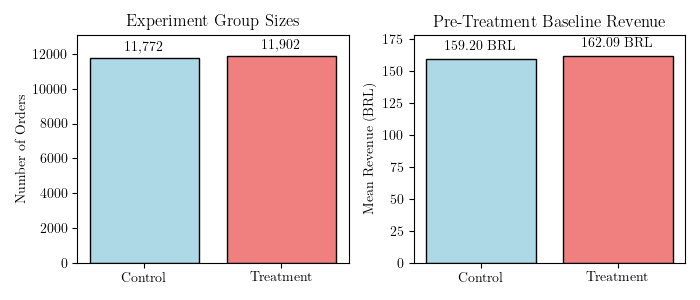

Visualization saved!


In [9]:
# Visualize the experiment groups

fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Plot 1: Group sizes
groups = ['Control', 'Treatment']
sizes = [control_count, treatment_count]
colors = ['lightblue', 'lightcoral']

axes[0].bar(groups, sizes, color=colors, edgecolor='black')
axes[0].set_ylabel('Number of Orders')
axes[0].set_title('Experiment Group Sizes')
axes[0].set_ylim(0, max(sizes) * 1.1)

for i, v in enumerate(sizes):
    axes[0].text(i, v + 200, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Baseline revenue comparison
baseline_means = [control_baseline, treatment_baseline]

axes[1].bar(groups, baseline_means, color=colors, edgecolor='black')
axes[1].set_ylabel('Mean Revenue (BRL)')
axes[1].set_title('Pre-Treatment Baseline Revenue')
axes[1].set_ylim(0, max(baseline_means) * 1.1)

for i, v in enumerate(baseline_means):
    axes[1].text(i, v + 5, f'{v:.2f} BRL', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/experiment_design_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved!")

## Experiment Design Complete

### Key Parameters
- **Sample size per group:** 11,837 orders
- **Total sample size:** 23,674 orders
- **Significance level:** α = 0.05
- **Statistical power:** 80%
- **Minimum detectable effect:** 5% revenue increase (8.03 BRL)

### Randomisation
- Random 50/50 split
- Groups are balanced (difference: 2.89 BRL)
- Seed set for reproducibility (seed=42)

### Expected Outcome
If treatment is effective:
- Control group: ~159.20 BRL per order
- Treatment group: ~167.23 BRL per order (5% increase)
- Statistical significance: p < 0.05